# **Homework 7 - Bert (Question Answering)**

If you have any questions, feel free to email us at mlta-2022-spring@googlegroups.com



Slide:    [Link](https://docs.google.com/presentation/d/1H5ZONrb2LMOCixLY7D5_5-7LkIaXO6AGEaV2mRdTOMY/edit?usp=sharing)　Kaggle: [Link](https://www.kaggle.com/c/ml2022spring-hw7)　Data: [Link](https://drive.google.com/uc?id=1AVgZvy3VFeg0fX-6WQJMHPVrx3A-M1kb)




## Task description
- Chinese Extractive Question Answering
  - Input: Paragraph + Question
  - Output: Answer

- Objective: Learn how to fine tune a pretrained model on downstream task using transformers

- Todo
    - Fine tune a pretrained chinese BERT model
    - Change hyperparameters (e.g. doc_stride)
    - Apply linear learning rate decay
    - Try other pretrained models
    - Improve preprocessing
    - Improve postprocessing
- Training tips
    - Automatic mixed precision
    - Gradient accumulation
    - Ensemble

- Estimated training time (tesla t4 with automatic mixed precision enabled)
    - Simple: 8mins
    - Medium: 8mins
    - Strong: 25mins
    - Boss: 2.5hrs
  

## Download Dataset

In [1]:
"""
# Download link 1
!gdown --id '1AVgZvy3VFeg0fX-6WQJMHPVrx3A-M1kb' --output hw7_data.zip

# Download Link 2 (if the above link fails)
# !gdown --id '1qwjbRjq481lHsnTrrF4OjKQnxzgoLEFR' --output hw7_data.zip

# Download Link 3 (if the above link fails)
# !gdown --id '1QXuWjNRZH6DscSd6QcRER0cnxmpZvijn' --output hw7_data.zip

!unzip -o hw7_data.zip

# For this HW, K80 < P4 < T4 < P100 <= T4(fp16) < V100
!nvidia-smi
"""

"\n# Download link 1\n!gdown --id '1AVgZvy3VFeg0fX-6WQJMHPVrx3A-M1kb' --output hw7_data.zip\n\n# Download Link 2 (if the above link fails)\n# !gdown --id '1qwjbRjq481lHsnTrrF4OjKQnxzgoLEFR' --output hw7_data.zip\n\n# Download Link 3 (if the above link fails)\n# !gdown --id '1QXuWjNRZH6DscSd6QcRER0cnxmpZvijn' --output hw7_data.zip\n\n!unzip -o hw7_data.zip\n\n# For this HW, K80 < P4 < T4 < P100 <= T4(fp16) < V100\n!nvidia-smi\n"

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml2022spring-hw7/hw7_train.json
/kaggle/input/ml2022spring-hw7/hw7_dev.json
/kaggle/input/ml2022spring-hw7/hw7_test.json


In [3]:
!nvidia-smi

Sun Sep  1 10:28:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Install transformers

Documentation for the toolkit:　https://huggingface.co/transformers/

In [4]:
pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Note: you may need to restart the kernel to use updated packages.


In [5]:
# You are allowed to change version of transformers or use other toolkits
# !pip install tokenizers==0.10.3
# !pip install transformers==4.5.0

## Import Packages

[transformers-BERT](https://huggingface.co/docs/transformers/model_doc/bert)

In [6]:
import json
import numpy as np
import random
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW, BertForQuestionAnswering, BertTokenizerFast

from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Fix random seed for reproducibility
def same_seeds(seed):
	  torch.manual_seed(seed)
	  if torch.cuda.is_available():
		    torch.cuda.manual_seed(seed)
		    torch.cuda.manual_seed_all(seed)
	  np.random.seed(seed)
	  random.seed(seed)
	  torch.backends.cudnn.benchmark = False
	  torch.backends.cudnn.deterministic = True
same_seeds(0)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [7]:
# Change "fp16_training" to True to support automatic mixed precision training (fp16)
fp16_training = False

if fp16_training:
    !pip install accelerate==0.2.0
    from accelerate import Accelerator
    accelerator = Accelerator(fp16=True)
    device = accelerator.device

# Documentation for the toolkit:  https://huggingface.co/docs/accelerate/

## Load Model and Tokenizer






In [8]:
model = BertForQuestionAnswering.from_pretrained("bert-base-chinese").to(device)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-chinese")

# You can safely ignore the warning message (it pops up because new prediction heads for QA are initialized randomly)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['qa_out

## Read Data

- Training set: 31690 QA pairs
- Dev set: 4131  QA pairs
- Test set: 4957  QA pairs

- {train/dev/test}_questions:
  - List of dicts with the following keys:
   - id (int)
   - paragraph_id (int)
   - question_text (string)
   - answer_text (string)
   - answer_start (int)
   - answer_end (int)
- {train/dev/test}_paragraphs:
  - List of strings
  - paragraph_ids in questions correspond to indexs in paragraphs
  - A paragraph may be used by several questions

In [9]:
# 深度优先搜索（DFS）来遍历指定目录及其子目录，并打印出目录结构
import os
import os.path

def dfs_showdir(path, depth):
    if depth == 0:
        print("root:[" + path + "]") # 深度为0打印根目录

    for item in os.listdir(path): # 获取当前目录下所有的文件和子目录
        if '.git' not in item:
            print("|      " * depth + "+--" + item) # 用 | 乘以当前深度来控制缩进，然后打印出当前项目名称

            newitem = path +'/'+ item #构建新的路径
            if os.path.isdir(newitem): # 检查是否是一个目录，是的话则递归调用，并将深度加1
                dfs_showdir(newitem, depth +1)

dfs_showdir('../', 0)

root:[../]
+--src
|      +--script.ipynb
+--lib
|      +--kaggle
|      |      +--gcp.py
+--input
|      +--ml2022spring-hw7
|      |      +--hw7_train.json
|      |      +--hw7_dev.json
|      |      +--hw7_test.json
+--working
|      +--__notebook__.ipynb


In [10]:
def read_data(file):
    with open(file, 'r', encoding="utf-8") as reader:
        data = json.load(reader)
    return data["questions"], data["paragraphs"]

"""kaggle中直接查看这三个json文件只有questions 没有paragraphs，但是实际上有"""
# train_questions, train_paragraphs = read_data("hw7_train.json")
# dev_questions, dev_paragraphs = read_data("hw7_dev.json")
# test_questions, test_paragraphs = read_data("hw7_test.json")
train_questions, train_paragraphs = read_data("../input/ml2022spring-hw7/hw7_train.json")
dev_questions, dev_paragraphs = read_data("../input/ml2022spring-hw7/hw7_dev.json")
test_questions, test_paragraphs = read_data("../input/ml2022spring-hw7/hw7_test.json")

In [11]:
np.array(train_questions).size # train_questions是个列表
train_questions[0]

{'id': 0,
 'paragraph_id': 3884,
 'question_text': '羅馬教皇利奧三世在800年正式加冕誰為羅馬人的皇帝?',
 'answer_text': '查理大帝',
 'answer_start': 141,
 'answer_end': 144}

## Tokenize Data

In [12]:
# Tokenize questions and paragraphs separately
# 「add_special_tokens」 is set to False since special tokens will be added when tokenized questions and paragraphs are combined in datset __getitem__

train_questions_tokenized = tokenizer([train_question["question_text"] for train_question in train_questions], add_special_tokens=False)
dev_questions_tokenized = tokenizer([dev_question["question_text"] for dev_question in dev_questions], add_special_tokens=False)
test_questions_tokenized = tokenizer([test_question["question_text"] for test_question in test_questions], add_special_tokens=False)

train_paragraphs_tokenized = tokenizer(train_paragraphs, add_special_tokens=False)
dev_paragraphs_tokenized = tokenizer(dev_paragraphs, add_special_tokens=False)
test_paragraphs_tokenized = tokenizer(test_paragraphs, add_special_tokens=False)

# You can safely ignore the warning message as tokenized sequences will be futher processed in datset __getitem__ before passing to model

Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors


## Dataset and Dataloader

**Padding**
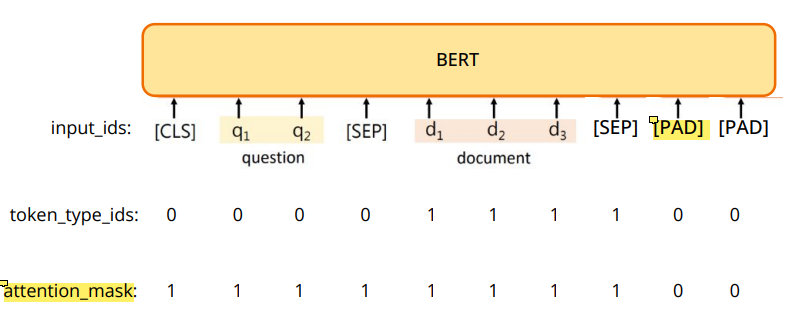

In [13]:
class QA_Dataset(Dataset):
    def __init__(self, split, questions, tokenized_questions, tokenized_paragraphs):
        self.split = split
        self.questions = questions
        self.tokenized_questions = tokenized_questions
        self.tokenized_paragraphs = tokenized_paragraphs
        self.max_question_len = 40
        self.max_paragraph_len = 150

        ##### TODO: Change value of doc_stride #####
        # self.doc_stride = 150
        self.doc_stride = 150 # 段落滑动窗口的步长

        # Input sequence length = [CLS] + question + [SEP] + paragraph + [SEP]
        self.max_seq_len = 1 + self.max_question_len + 1 + self.max_paragraph_len + 1   # seq_len: 193

    # 返回数据集中的问题数量
    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        tokenized_question = self.tokenized_questions[idx]
        tokenized_paragraph = self.tokenized_paragraphs[question["paragraph_id"]]

        ##### TODO: Preprocessing #####
        # Hint: How to prevent model from learning something it should not learn

        if self.split == "train":
            # Convert answer's start/end positions in paragraph_text to start/end positions in tokenized_paragraph
            answer_start_token = tokenized_paragraph.char_to_token(question["answer_start"])
            answer_end_token = tokenized_paragraph.char_to_token(question["answer_end"])

            # A single window is obtained by slicing the portion of paragraph containing the answer
            # 再training中paragraph的截取依据的是answer的id
            mid = (answer_start_token + answer_end_token) // 2
            paragraph_start = max(0, min(mid - self.max_paragraph_len // 2, len(tokenized_paragraph) - self.max_paragraph_len))
            paragraph_end = paragraph_start + self.max_paragraph_len
            """
            start_min = max(0, answer_end_token - self.max_paragraph_len + 1)
            start_max = min(answer_start_token, len(tokenized_paragraph) - self.max_paragraph_len)
            start_max = max(start_min, start_max)
            paragraph_start = random.randint(start_min, start_max + 1)
            """

            # Slice question/paragraph and add special tokens (101: CLS, 102: SEP)
            input_ids_question = [101] + tokenized_question.ids[:self.max_question_len] + [102]
            input_ids_paragraph = tokenized_paragraph.ids[paragraph_start : paragraph_end] + [102]

            # Convert answer's start/end positions in tokenized_paragraph to start/end positions in the window
            answer_start_token += len(input_ids_question) - paragraph_start # 要将问题和答案拼接在一起输入，所以要调整一下答案的起始和结束的位置
            answer_end_token += len(input_ids_question) - paragraph_start

            # Pad sequence and obtain inputs to model
            input_ids, token_type_ids, attention_mask = self.padding(input_ids_question, input_ids_paragraph)
            return torch.tensor(input_ids), torch.tensor(token_type_ids), torch.tensor(attention_mask), answer_start_token, answer_end_token

        # Validation/Testing
        else:
            input_ids_list, token_type_ids_list, attention_mask_list = [], [], []

            # Paragraph is split into several windows, each with start positions separated by step "doc_stride"
            for i in range(0, len(tokenized_paragraph), self.doc_stride):

                # Slice question/paragraph and add special tokens (101: CLS, 102: SEP)
                # validation/testing 中paragraph的截取靠的是Windows滑动，每次滑动的间隔是doc_stride
                input_ids_question = [101] + tokenized_question.ids[:self.max_question_len] + [102]
                input_ids_paragraph = tokenized_paragraph.ids[i : i + self.max_paragraph_len] + [102]

                # Pad sequence and obtain inputs to model
                input_ids, token_type_ids, attention_mask = self.padding(input_ids_question, input_ids_paragraph)

                input_ids_list.append(input_ids)
                token_type_ids_list.append(token_type_ids)
                attention_mask_list.append(attention_mask)

            return torch.tensor(input_ids_list), torch.tensor(token_type_ids_list), torch.tensor(attention_mask_list)

    def padding(self, input_ids_question, input_ids_paragraph):
        # Pad zeros if sequence length is shorter than max_seq_len 都加到193
        padding_len = self.max_seq_len - len(input_ids_question) - len(input_ids_paragraph)
        # Indices of input sequence tokens in the vocabulary
        input_ids = input_ids_question + input_ids_paragraph + [0] * padding_len
        # Segment token indices to indicate first and second portions of the inputs. Indices are selected in [0, 1]
        token_type_ids = [0] * len(input_ids_question) + [1] * len(input_ids_paragraph) + [0] * padding_len
        # Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]
        attention_mask = [1] * (len(input_ids_question) + len(input_ids_paragraph)) + [0] * padding_len

        return input_ids, token_type_ids, attention_mask

train_set = QA_Dataset("train", train_questions, train_questions_tokenized, train_paragraphs_tokenized)
dev_set = QA_Dataset("dev", dev_questions, dev_questions_tokenized, dev_paragraphs_tokenized)
test_set = QA_Dataset("test", test_questions, test_questions_tokenized, test_paragraphs_tokenized)

train_batch_size = 32

# Note: Do NOT change batch size of dev_loader / test_loader !
# Although batch size=1, it is actually a batch consisting of several windows from the same QA pair
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, pin_memory=True)
dev_loader = DataLoader(dev_set, batch_size=1, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, pin_memory=True)

In [14]:
for batch in train_loader:
    print(batch[0].shape)
    break 

torch.Size([32, 193])


## Function for Evaluation

In [15]:
def evaluate(data, output):
    ##### TODO: Postprocessing #####
    # There is a bug and room for improvement in postprocessing
    # Hint: Open your prediction file to see what is wrong

    answer = ''
    max_prob = float('-inf')
    num_of_windows = data[0].shape[1]
    
    for k in range(num_of_windows):
        # Obtain answer by choosing the most probable start position / end position
        # start_logits 和 end_logits都是model的output，分别表示Span-start/end scores (before SoftMax) [batchsize, seq_length]
        start_prob, start_index = torch.max(output.start_logits[k], dim=0) #在行上查找最大值
        end_prob, end_index = torch.max(output.end_logits[k], dim=0)
        
        """
        # 如果开始索引比结束索引大就跳过
        if start_index > end_index:
            continue
        """
        
        # Probability of answer is calculated as sum of start_prob and end_prob
        prob = start_prob + end_prob

        # Replace answer if calculated probability is larger than previous windows
        if prob > max_prob:
            max_prob = prob
            # Convert tokens to chars (e.g. [1920, 7032] --> "大 金")
            answer = tokenizer.decode(data[0][0][k][start_index : end_index + 1]) # data是个列表，input_ids=data[0], token_type_ids=data[1], attention_mask=data[2], start_positions=data[3], end_positions=data[4]，对于data[0]来说，[batchsize,windows number, seq_length]

    # Remove spaces in answer (e.g. "大 金" --> "大金")
    return answer.replace(' ','')

## Training

In [16]:
num_epoch = 10
validation = True  # 在每个epoch后开启交叉验证
logging_step = 100
learning_rate = 1e-4
optimizer = AdamW(model.parameters(), lr=learning_rate)
"""
# 加的
from transformers import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=1000)
"""
if fp16_training:
    model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

model.train()

print("Start Training ...")

for epoch in range(num_epoch):
    step = 1
    train_loss = train_acc = 0 # 初始化准确率和损失

    for data in tqdm(train_loader): # data是一个batch上的
        # Load all data into GPU
        data = [i.to(device) for i in data]

        # Model inputs: input_ids, token_type_ids, attention_mask, anwser_start_positions, anwser_end_positions (Note: only "input_ids" is mandatory)
        # Model outputs: start_logits, end_logits, loss (return when anwser_start_positions/anwser_end_positions are provided, is the sum of a Cross-Entropy for the start and end positions.)
        output = model(input_ids=data[0], token_type_ids=data[1], attention_mask=data[2], start_positions=data[3], end_positions=data[4])

        # print("output.start_logits shape: {}".format(output.start_logits.shape))
        # Choose the most probable start position / end position
        start_index = torch.argmax(output.start_logits, dim=1)  # output.start_logits [batch_size, seq_length] seq_length就是前面在dataset中定义的max_seq_len
        end_index = torch.argmax(output.end_logits, dim=1)

        # Prediction is correct only if both start_index and end_index are correct
        train_acc += ((start_index == data[3]) & (end_index == data[4])).float().mean()
        train_loss += output.loss

        if fp16_training:
            accelerator.backward(output.loss)
        else:
            output.loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        step += 1

        ##### TODO: Apply linear learning rate decay #####
        # scheduler.step()

        # Print training loss and accuracy over past logging step
        if step % logging_step == 0:
            print(f"Epoch {epoch + 1} | Step {step} | loss = {train_loss.item() / logging_step:.3f}, acc = {train_acc / logging_step:.3f}")
            train_loss = train_acc = 0

    if validation:
        print("Evaluating Dev Set ...")
        model.eval()
        with torch.no_grad():
            dev_acc = 0
            for i, data in enumerate(tqdm(dev_loader)):
                output = model(input_ids=data[0].squeeze(dim=0).to(device), token_type_ids=data[1].squeeze(dim=0).to(device),
                       attention_mask=data[2].squeeze(dim=0).to(device))
                # prediction is correct only if answer text exactly matches
                dev_acc += evaluate(data, output) == dev_questions[i]["answer_text"] # 只有输出与目标完全一样才算准确
            print(f"Validation | Epoch {epoch + 1} | acc = {dev_acc / len(dev_loader):.3f}")
        model.train()

# Save a model and its configuration file to the directory 「saved_model」
# i.e. there are two files under the direcory 「saved_model」: 「pytorch_model.bin」 and 「config.json」
# Saved model can be re-loaded using 「model = BertForQuestionAnswering.from_pretrained("saved_model")」
print("Saving Model ...")
model_save_dir = "saved_model"
model.save_pretrained(model_save_dir)

Start Training ...


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/991 [00:00<?, ?it/s]

Epoch 1 | Step 100 | loss = 1.593, acc = 0.462
Epoch 1 | Step 200 | loss = 0.828, acc = 0.668
Epoch 1 | Step 300 | loss = 0.774, acc = 0.682
Epoch 1 | Step 400 | loss = 0.712, acc = 0.704
Epoch 1 | Step 500 | loss = 0.661, acc = 0.723
Epoch 1 | Step 600 | loss = 0.628, acc = 0.729
Epoch 1 | Step 700 | loss = 0.586, acc = 0.744
Epoch 1 | Step 800 | loss = 0.609, acc = 0.752
Epoch 1 | Step 900 | loss = 0.583, acc = 0.752
Evaluating Dev Set ...


  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 1 | acc = 0.470


  0%|          | 0/991 [00:00<?, ?it/s]

Epoch 2 | Step 100 | loss = 0.353, acc = 0.822
Epoch 2 | Step 200 | loss = 0.355, acc = 0.826
Epoch 2 | Step 300 | loss = 0.352, acc = 0.825
Epoch 2 | Step 400 | loss = 0.367, acc = 0.829
Epoch 2 | Step 500 | loss = 0.385, acc = 0.812
Epoch 2 | Step 600 | loss = 0.378, acc = 0.829
Epoch 2 | Step 700 | loss = 0.406, acc = 0.815
Epoch 2 | Step 800 | loss = 0.383, acc = 0.818
Epoch 2 | Step 900 | loss = 0.387, acc = 0.823
Evaluating Dev Set ...


  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 2 | acc = 0.454


  0%|          | 0/991 [00:00<?, ?it/s]

Epoch 3 | Step 100 | loss = 0.244, acc = 0.869
Epoch 3 | Step 200 | loss = 0.261, acc = 0.871
Epoch 3 | Step 300 | loss = 0.269, acc = 0.856
Epoch 3 | Step 400 | loss = 0.275, acc = 0.861
Epoch 3 | Step 500 | loss = 0.266, acc = 0.876
Epoch 3 | Step 600 | loss = 0.291, acc = 0.851
Epoch 3 | Step 700 | loss = 0.276, acc = 0.861
Epoch 3 | Step 800 | loss = 0.284, acc = 0.859
Epoch 3 | Step 900 | loss = 0.294, acc = 0.851
Evaluating Dev Set ...


  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 3 | acc = 0.469


  0%|          | 0/991 [00:00<?, ?it/s]

Epoch 4 | Step 100 | loss = 0.186, acc = 0.897
Epoch 4 | Step 200 | loss = 0.204, acc = 0.892
Epoch 4 | Step 300 | loss = 0.202, acc = 0.897
Epoch 4 | Step 400 | loss = 0.255, acc = 0.871
Epoch 4 | Step 500 | loss = 0.239, acc = 0.871
Epoch 4 | Step 600 | loss = 0.250, acc = 0.879
Epoch 4 | Step 700 | loss = 0.230, acc = 0.881
Epoch 4 | Step 800 | loss = 0.235, acc = 0.886
Epoch 4 | Step 900 | loss = 0.265, acc = 0.871
Evaluating Dev Set ...


  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 4 | acc = 0.489


  0%|          | 0/991 [00:00<?, ?it/s]

Epoch 5 | Step 100 | loss = 0.163, acc = 0.904
Epoch 5 | Step 200 | loss = 0.164, acc = 0.912
Epoch 5 | Step 300 | loss = 0.165, acc = 0.919
Epoch 5 | Step 400 | loss = 0.176, acc = 0.912
Epoch 5 | Step 500 | loss = 0.201, acc = 0.894
Epoch 5 | Step 600 | loss = 0.194, acc = 0.904
Epoch 5 | Step 700 | loss = 0.196, acc = 0.901
Epoch 5 | Step 800 | loss = 0.325, acc = 0.841
Epoch 5 | Step 900 | loss = 0.300, acc = 0.852
Evaluating Dev Set ...


  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 5 | acc = 0.490


  0%|          | 0/991 [00:00<?, ?it/s]

Epoch 6 | Step 100 | loss = 0.176, acc = 0.899
Epoch 6 | Step 200 | loss = 0.157, acc = 0.919
Epoch 6 | Step 300 | loss = 0.150, acc = 0.924
Epoch 6 | Step 400 | loss = 0.154, acc = 0.925
Epoch 6 | Step 500 | loss = 0.199, acc = 0.905
Epoch 6 | Step 600 | loss = 0.184, acc = 0.911
Epoch 6 | Step 700 | loss = 0.203, acc = 0.899
Epoch 6 | Step 800 | loss = 0.156, acc = 0.921
Epoch 6 | Step 900 | loss = 0.170, acc = 0.910
Evaluating Dev Set ...


  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 6 | acc = 0.469


  0%|          | 0/991 [00:00<?, ?it/s]

Epoch 7 | Step 100 | loss = 0.095, acc = 0.937
Epoch 7 | Step 200 | loss = 0.096, acc = 0.951
Epoch 7 | Step 300 | loss = 0.114, acc = 0.940
Epoch 7 | Step 400 | loss = 0.101, acc = 0.945
Epoch 7 | Step 500 | loss = 0.132, acc = 0.933
Epoch 7 | Step 600 | loss = 0.129, acc = 0.928
Epoch 7 | Step 700 | loss = 0.148, acc = 0.925
Epoch 7 | Step 800 | loss = 0.156, acc = 0.921
Epoch 7 | Step 900 | loss = 0.151, acc = 0.923
Evaluating Dev Set ...


  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 7 | acc = 0.485


  0%|          | 0/991 [00:00<?, ?it/s]

Epoch 8 | Step 100 | loss = 0.098, acc = 0.941
Epoch 8 | Step 200 | loss = 0.086, acc = 0.959
Epoch 8 | Step 300 | loss = 0.108, acc = 0.947
Epoch 8 | Step 400 | loss = 0.113, acc = 0.938
Epoch 8 | Step 500 | loss = 0.125, acc = 0.938
Epoch 8 | Step 600 | loss = 0.246, acc = 0.903
Epoch 8 | Step 700 | loss = 0.333, acc = 0.851
Epoch 8 | Step 800 | loss = 0.264, acc = 0.875
Epoch 8 | Step 900 | loss = 0.205, acc = 0.889
Evaluating Dev Set ...


  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 8 | acc = 0.467


  0%|          | 0/991 [00:00<?, ?it/s]

Epoch 9 | Step 100 | loss = 0.112, acc = 0.933
Epoch 9 | Step 200 | loss = 0.121, acc = 0.938
Epoch 9 | Step 300 | loss = 0.116, acc = 0.938
Epoch 9 | Step 400 | loss = 0.127, acc = 0.935
Epoch 9 | Step 500 | loss = 0.119, acc = 0.941
Epoch 9 | Step 600 | loss = 0.132, acc = 0.938
Epoch 9 | Step 700 | loss = 0.108, acc = 0.944
Epoch 9 | Step 800 | loss = 0.119, acc = 0.943
Epoch 9 | Step 900 | loss = 0.122, acc = 0.936
Evaluating Dev Set ...


  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 9 | acc = 0.485


  0%|          | 0/991 [00:00<?, ?it/s]

Epoch 10 | Step 100 | loss = 0.078, acc = 0.950
Epoch 10 | Step 200 | loss = 0.088, acc = 0.953
Epoch 10 | Step 300 | loss = 0.080, acc = 0.957
Epoch 10 | Step 400 | loss = 0.101, acc = 0.946
Epoch 10 | Step 500 | loss = 0.114, acc = 0.943
Epoch 10 | Step 600 | loss = 0.103, acc = 0.947
Epoch 10 | Step 700 | loss = 0.115, acc = 0.944
Epoch 10 | Step 800 | loss = 0.115, acc = 0.946
Epoch 10 | Step 900 | loss = 0.101, acc = 0.947
Evaluating Dev Set ...


  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 10 | acc = 0.475
Saving Model ...


## Testing

In [17]:
print("Evaluating Test Set ...")

result = []

model.eval()
with torch.no_grad():
    for data in tqdm(test_loader):
        output = model(input_ids=data[0].squeeze(dim=0).to(device), token_type_ids=data[1].squeeze(dim=0).to(device),
                       attention_mask=data[2].squeeze(dim=0).to(device))
        result.append(evaluate(data, output))  # anwser

result_file = "result.csv"
with open(result_file, 'w') as f:
	  f.write("ID,Answer\n")
	  for i, test_question in enumerate(test_questions):
        # Replace commas in answers with empty strings (since csv is separated by comma)
        # Answers in kaggle are processed in the same way
		    f.write(f"{test_question['id']},{result[i].replace(',','')}\n")

print(f"Completed! Result is in {result_file}")

Evaluating Test Set ...


  0%|          | 0/4957 [00:00<?, ?it/s]

Completed! Result is in result.csv
